# SMS Spam Detection

Import Modules

In [70]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from nltk.corpus import words
from tqdm.notebook import tqdm
from symspellpy import SymSpell

Read the dataset into a Pandas DataFrame

In [71]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Exploratory Data Analysis

In [72]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [73]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
tqdm.pandas(desc='My bar!')
df["length"] = df["message"].progress_apply(len)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


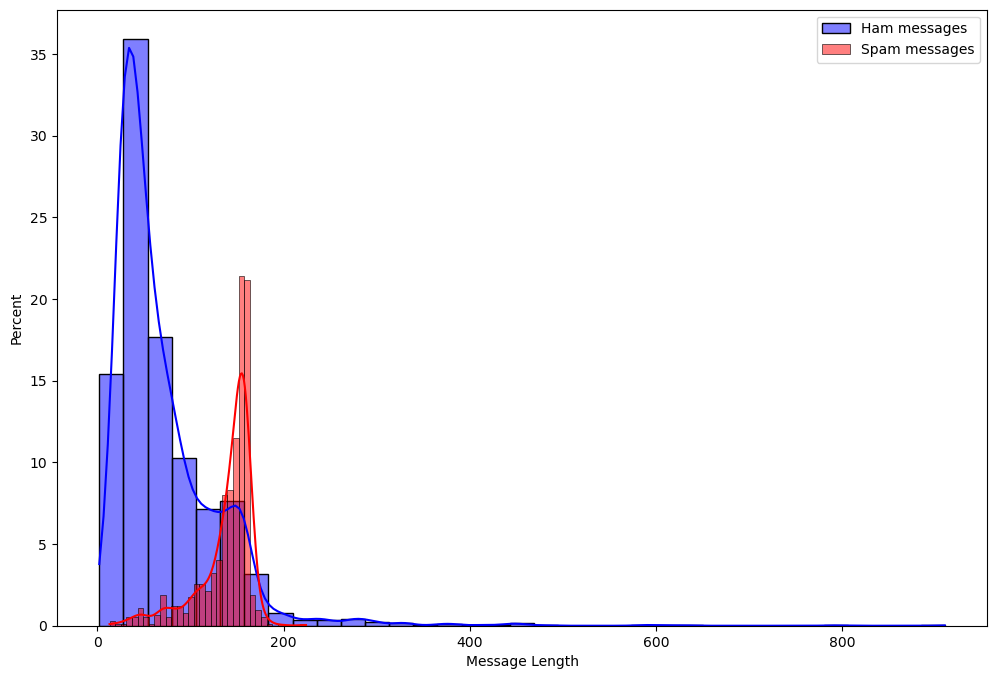

In [74]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["length"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["length"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Message Length")
plt.show()


In [75]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["length"], spam_data["length"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.6784415728544576
P-Value: 8.17299035435783e-290
The distributions are significantly different.


In [92]:
def count_words(text):
    return len(text.split(" "))
tqdm.pandas(desc='My bar!')
df["word_count"] = df["message"].progress_apply(count_words)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,symbols,capitals,misspelt,word_count
0,0,go jurong point crazy available bugis n great ...,111,0.081081,0.027027,0.312500,16
1,0,ok lar joking wif oni,29,0.206897,0.068966,0.800000,5
2,1,free entry wkly comp win fa cup final tkts 21s...,155,0.038710,0.064516,0.454545,22
3,0,dun say early hor c already say,49,0.122449,0.040816,0.285714,7
4,0,nah think goes usf lives around though,61,0.032787,0.032787,0.285714,7
...,...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,0.049689,0.055901,0.187500,16
5568,0,ì b going esplanade fr home,37,0.054054,0.054054,0.333333,6
5569,0,pity mood soany suggestions,57,0.122807,0.035088,0.250000,4
5570,0,guy bitching acted like id interested buying s...,125,0.008000,0.016000,0.142857,14


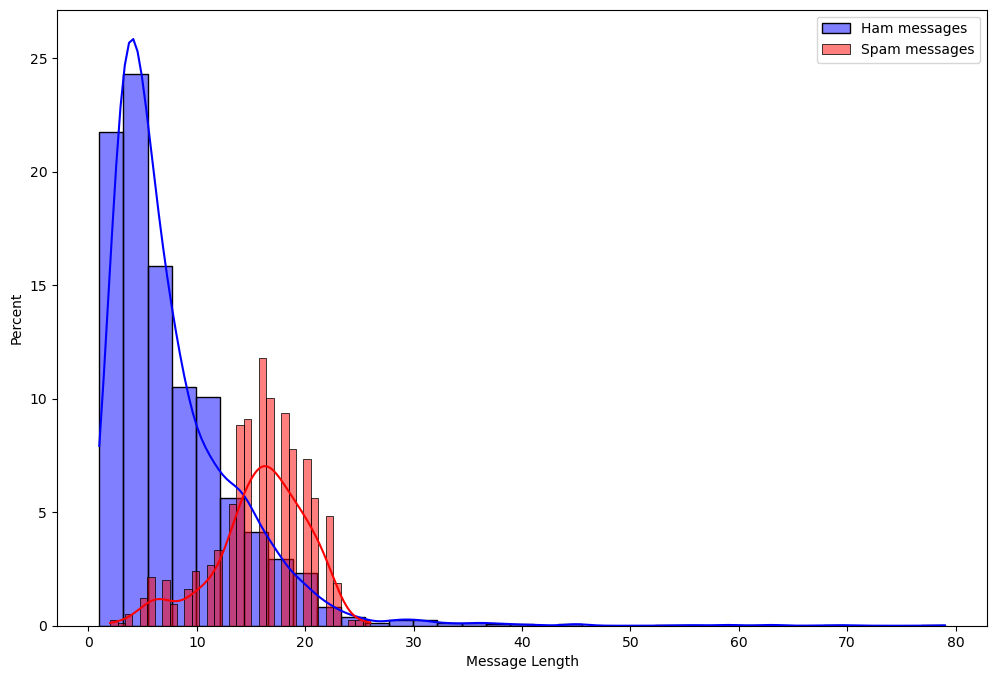

In [93]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["word_count"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["word_count"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Message Length")
plt.show()


In [103]:
df[(df["label"] == 0) & (df["word_count"] > 30)]["word_count"].describe()

count    40.000000
mean     42.250000
std      12.751571
min      31.000000
25%      33.000000
50%      37.000000
75%      45.000000
max      79.000000
Name: word_count, dtype: float64

In [97]:
df[df["label"] == 1]["word_count"].describe()

count    747.000000
mean      15.914324
std        4.268237
min        2.000000
25%       14.000000
50%       16.000000
75%       19.000000
max       26.000000
Name: word_count, dtype: float64

In [99]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["word_count"], spam_data["word_count"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.655595091939433
P-Value: 3.5795873231440907e-268
The distributions are significantly different.


In [76]:
def count_symbols(message):
    symbols = set(string.punctuation)
    count = sum(1 for char in message if char in symbols)
    return count / len(message)

df["symbols"] = df["message"].apply(count_symbols)
df

,label,message,length,symbols
0,0,"Go until jurong point, crazy.. Available only ...",111,0.081081
1,0,Ok lar... Joking wif u oni...,29,0.206897
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.038710
3,0,U dun say so early hor... U c already then say...,49,0.122449
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0.032787
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,0.049689
5568,0,Will Ì_ b going to esplanade fr home?,37,0.054054
5569,0,"Pity, * was in mood for that. So...any other s...",57,0.122807
5570,0,The guy did some bitching but I acted like i'd...,125,0.008000


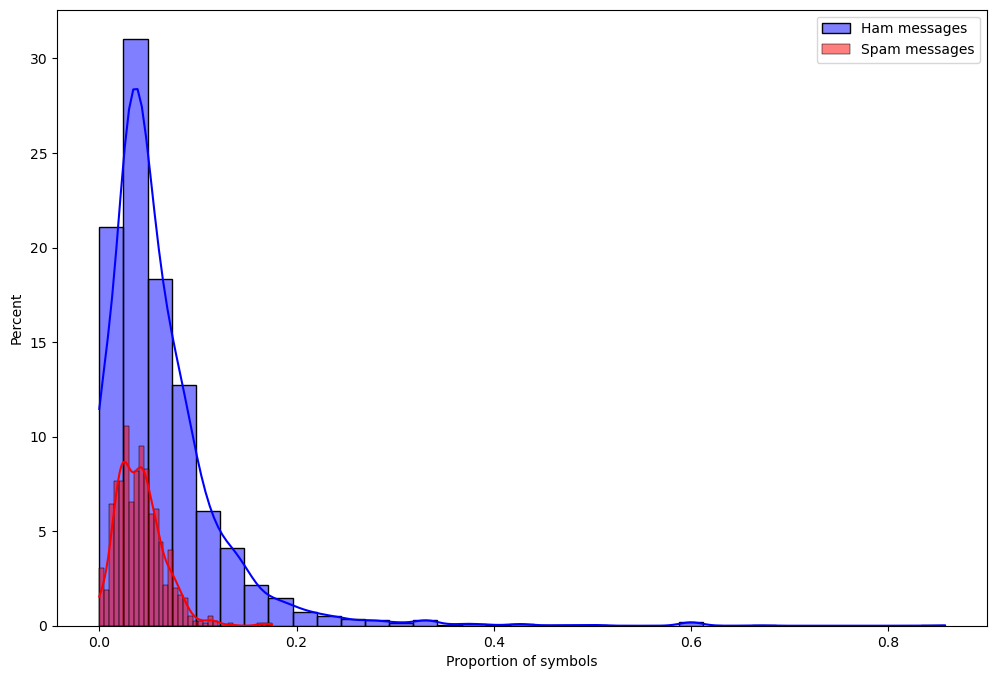

In [77]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["symbols"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["symbols"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of symbols")
plt.show()


In [78]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["symbols"], spam_data["symbols"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.21631201836707797
P-Value: 5.046492269780785e-27
The distributions are significantly different.


In [79]:
def count_capitals(message):
    count = sum(1 for char in message if char.isupper())
    return count / len(message)

tqdm.pandas()
df["capitals"] = df["message"].apply(count_capitals)
df

,label,message,length,symbols,capitals
0,0,"Go until jurong point, crazy.. Available only ...",111,0.081081,0.027027
1,0,Ok lar... Joking wif u oni...,29,0.206897,0.068966
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.038710,0.064516
3,0,U dun say so early hor... U c already then say...,49,0.122449,0.040816
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0.032787,0.032787
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,0.049689,0.055901
5568,0,Will Ì_ b going to esplanade fr home?,37,0.054054,0.054054
5569,0,"Pity, * was in mood for that. So...any other s...",57,0.122807,0.035088
5570,0,The guy did some bitching but I acted like i'd...,125,0.008000,0.016000


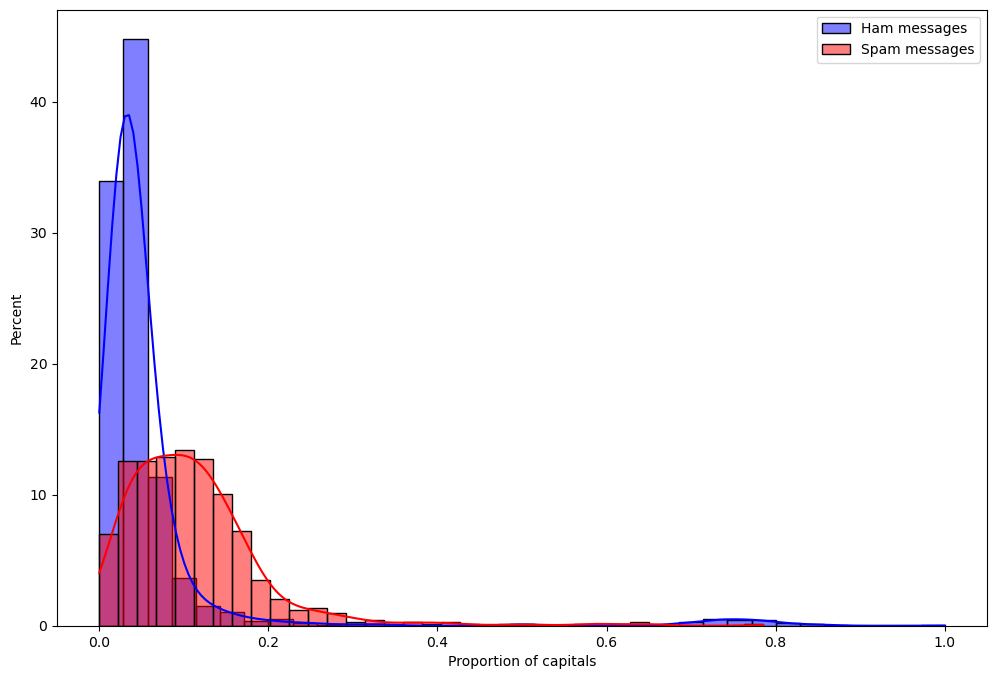

In [80]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["capitals"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["capitals"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of capitals")
plt.show()


In [81]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["capitals"], spam_data["capitals"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.5352696450742521
P-Value: 4.415291113781373e-172
The distributions are significantly different.


In [82]:
df[df["label"] == 1]

,label,message,length,symbols,capitals
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.038710,0.064516
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,0.054054,0.047297
8,1,WINNER!! As a valued network customer you have...,158,0.037975,0.075949
9,1,Had your mobile 11 months or more? U R entitle...,154,0.012987,0.090909
11,1,"SIX chances to win CASH! From 100 to 20,000 po...",136,0.058824,0.125000
...,...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,90,0.033333,0.188889
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,0.031250,0.650000
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,160,0.050000,0.125000
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,147,0.020408,0.095238


In [83]:
def process_text(message):
    message = "".join([char for char in message if char not in string.punctuation]).lower()
    STOPWORDS  = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    return ' '.join([word for word in message.split() if word not in STOPWORDS])
df["message"] = df["message"].apply(process_text)
df

,label,message,length,symbols,capitals
0,0,go jurong point crazy available bugis n great ...,111,0.081081,0.027027
1,0,ok lar joking wif oni,29,0.206897,0.068966
2,1,free entry wkly comp win fa cup final tkts 21s...,155,0.038710,0.064516
3,0,dun say early hor c already say,49,0.122449,0.040816
4,0,nah think goes usf lives around though,61,0.032787,0.032787
...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,0.049689,0.055901
5568,0,ì b going esplanade fr home,37,0.054054,0.054054
5569,0,pity mood soany suggestions,57,0.122807,0.035088
5570,0,guy bitching acted like id interested buying s...,125,0.008000,0.016000


In [84]:
def freq_incorrect(text):
    WORDS = text.split(" ")
    english_vocab = set(w.lower() for w in words.words())
    misspelled = len([word for word in WORDS if word not in english_vocab])
    return misspelled / len(WORDS)

#tqdm.pandas(desc='My bar!')
#df["misspelt"] = df["message"].progress_apply(freq_incorrect)
#df

In [85]:
from nltk.corpus import brown
from collections import Counter
import os

# Download the Brown corpus (if not already downloaded)
nltk.download('brown')

# Access the Brown corpus
brown_words = brown.words()

# Calculate word frequencies
word_freq = Counter(brown_words)

# Sort the words by frequency
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

file_path = "custom_frequency_dictionary.txt"
# Create a custom frequency dictionary file
if not os.path.exists(file_path):
    with open(file_path, "w") as f:
        for word, freq in sorted_word_freq:
            f.write(f"{word} {freq}\n")


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\dtren\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [87]:
def freq_incorrect(text):
    WORDS = text.split(" ")
    sym_spell = SymSpell()
    max_edit_distance = 1
    sym_spell.load_dictionary("custom_frequency_dictionary.txt", term_index=0, count_index=1)
    misspelled = sum(map(lambda word: 1 if len([obj.term for obj in sym_spell.lookup(word, max_edit_distance) if obj.term != word]) > 0 else 0, WORDS))

    return misspelled / len(WORDS)

tqdm.pandas(desc='My bar!')
df["misspelt"] = df["message"].progress_apply(freq_incorrect)
df

My bar!:   0%|          | 0/5572 [00:00<?, ?it/s]

,label,message,length,symbols,capitals,misspelt
0,0,go jurong point crazy available bugis n great ...,111,0.081081,0.027027,0.312500
1,0,ok lar joking wif oni,29,0.206897,0.068966,0.800000
2,1,free entry wkly comp win fa cup final tkts 21s...,155,0.038710,0.064516,0.454545
3,0,dun say early hor c already say,49,0.122449,0.040816,0.285714
4,0,nah think goes usf lives around though,61,0.032787,0.032787,0.285714
...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,0.049689,0.055901,0.187500
5568,0,ì b going esplanade fr home,37,0.054054,0.054054,0.333333
5569,0,pity mood soany suggestions,57,0.122807,0.035088,0.250000
5570,0,guy bitching acted like id interested buying s...,125,0.008000,0.016000,0.142857


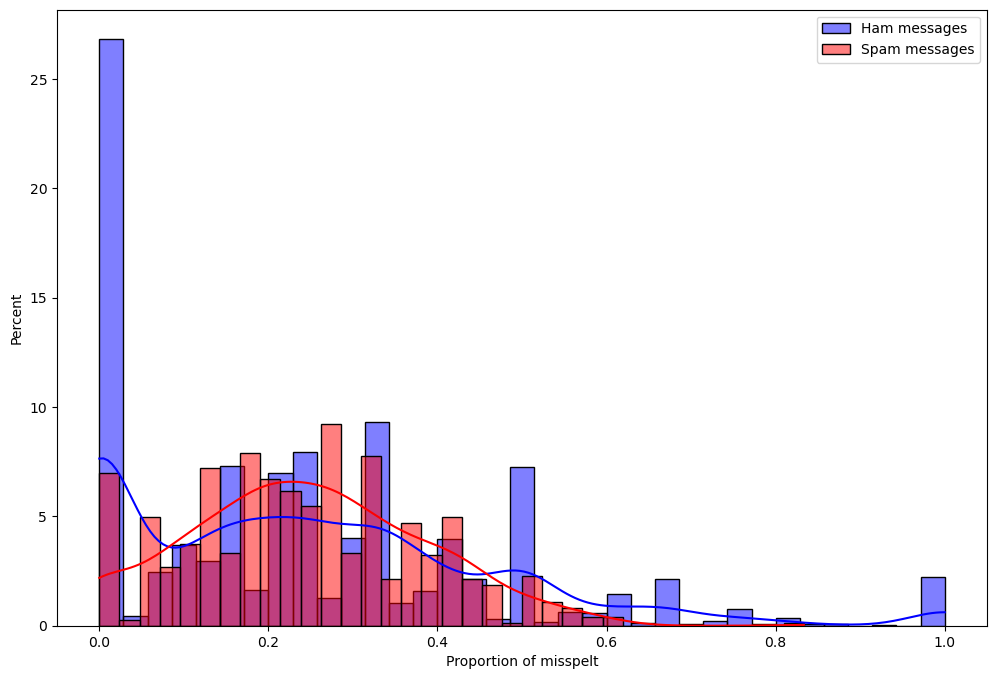

In [88]:
plt.figure(figsize=(12, 8))

# Filter data for label=0 (Ham messages)
ham_data = df[df["label"] == 0]
sns.histplot(ham_data["misspelt"], bins=35, color='blue', label='Ham messages', kde=True, common_norm=False, stat="percent")

# Filter data for label=1 (Spam messages)
spam_data = df[df["label"] == 1]
sns.histplot(spam_data["misspelt"], bins=35, color='red', label='Spam messages', kde=True, common_norm=False, stat="percent")

plt.legend()
plt.xlabel("Proportion of misspelt")
plt.show()

In [89]:
# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(ham_data["misspelt"], spam_data["misspelt"])

# Print the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-Value:", p_value)

# Determine statistical significance
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

Kolmogorov-Smirnov Statistic: 0.20023277913033827
P-Value: 3.438413810862978e-23
The distributions are significantly different.


In [104]:
df

,label,message,length,symbols,capitals,misspelt,word_count
0,0,go jurong point crazy available bugis n great ...,111,0.081081,0.027027,0.312500,16
1,0,ok lar joking wif oni,29,0.206897,0.068966,0.800000,5
2,1,free entry wkly comp win fa cup final tkts 21s...,155,0.038710,0.064516,0.454545,22
3,0,dun say early hor c already say,49,0.122449,0.040816,0.285714,7
4,0,nah think goes usf lives around though,61,0.032787,0.032787,0.285714,7
...,...,...,...,...,...,...,...
5567,1,2nd time tried contact å£750 pound prize claim...,161,0.049689,0.055901,0.187500,16
5568,0,ì b going esplanade fr home,37,0.054054,0.054054,0.333333,6
5569,0,pity mood soany suggestions,57,0.122807,0.035088,0.250000,4
5570,0,guy bitching acted like id interested buying s...,125,0.008000,0.016000,0.142857,14
